
# Parallel / Monte Carlo: HW12

CUNY MSDA - DATA 602: Advanced Programming Techniques<br>
_Author - Walt Wells_

In [1]:
import pandas as pd
import numpy as np
import ipyparallel as ipp
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

This homework will get your feet wet with some basic parallel computing approaches.  

* Take your solution from Homework 11 and complete the Monte Carlo step (step 6) in parallel.  There are many ways you can go about doing this, and I'm not looking for anything too complicated.  If you can get multiple processes crunching the data together, that is great.  Using IPython’s built-in tools would be a great method. 
* Compare the timing for your solution in homework 11 and this parallel solution.  This is similar to what you did in homeworks 6 and 7.  Ideally, you'll see some speed improvement.  The amount you see will largely be based the capabilities of your hardware, and less on the software implementation.  There is additional overhead for running an operation in parallel, so speed gains will be more obvious with a larger number of calculations.

### Load and Clean Data

In [2]:
url = 'https://raw.githubusercontent.com/wwells/CUNY_DATA_602/master/L11/apple.2011.csv'
apple = pd.read_csv(url, names = ['date', 'price', 'per_change'], skiprows=1)
apple['date'] = pd.to_datetime(apple['date'])
apple['per_change'] = pd.to_numeric(apple['per_change'], errors='coerce')

### Get Values, Function to Generate Walk

In [3]:
mu = np.mean(apple['per_change'])
sigma = np.std(apple['per_change'])
lastprice = apple.price.iloc[-1]

In [4]:
def montecarlowalk(walklength):
    price = lastprice
    randlist = np.random.normal(mu, sigma, walklength)
    for i in randlist:
        price = price + price * i
    return price

## Time Local

### Local Timer Func

In [5]:
def localtimer(n):
    t0 = time.time()
    monte = [montecarlowalk(20) for i in range(n)]
    VaR99 = np.percentile(monte, 1)
    t1 = time.time()
    t = t1-t0
    return t

### Time 10K, 100K, 1Mil Loops

In [6]:
l10 = localtimer(10000)
l100 = localtimer(100000)
l1m = localtimer(1000000)

## Time Parallel

### Configure client, engines, import objects

In [7]:
clients = ipp.Client()
clients.block = True
ar = clients[:].apply_async(os.getpid)
pid_map = ar.get_dict()
dview = clients.direct_view()

##get env variables in place on engines
%px import numpy as np; import timeit
dview.push({"montecarlowalk": montecarlowalk, "lastprice": lastprice, 
            "mu": mu, "sigma": sigma})
print pid_map

{0: 24941, 1: 24942, 2: 24943, 3: 24944}


### Parallel Timer Func

In [8]:
def paralleltimer(n):
    t0 = time.time()
    dview.push({'n': n})
    %px enginenum = n / 4
    %px monte = [montecarlowalk(20) for i in range(enginenum)]
    monte = dview.gather('monte')
    VaR99 = np.percentile(monte, 1)
    t1 = time.time()
    t = t1-t0
    return t

### Time 10K, 100K, 1Mil Loops

In [9]:
p10 = paralleltimer(10000)
p100 = paralleltimer(100000)
p1m = paralleltimer(1000000)

## Summary

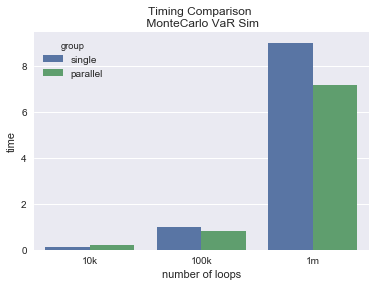

In [10]:
timing = pd.DataFrame({'group': ['single', 'single', 'single', 'parallel', 'parallel', 'parallel'],
         'num': ['10k', '100k', '1m', '10k', '100k', '1m'], 
         'time': [l10, l100, l1m, p10, p100, p1m]})
ax = sns.barplot(x="num", y="time", hue="group", data=timing);
ax.set(xlabel='number of loops', ylabel='time', title="Timing Comparison \n MonteCarlo VaR Sim")
plt.show()

### References

* http://minrk.github.io/scipy-tutorial-2011/
* http://seaborn.pydata.org/tutorial/categorical.html
* http://davidmasad.com/blog/simulation-with-ipyparallel/